In [2]:
import matplotlib.pyplot as plt
import numpy as np
import struct

# Updated TYPE_MAP to include only floating-point types
TYPE_MAP = {
    4353: ('I1', 0.125),  # 1-bit boolean/flag
    4354: ('I8', 1),      # 8-bit integer
    4355: ('I32', 4),     # 32-bit integer
    4356: ('I64', 8),     # 64-bit integer
    4357: ('I128', 16),   # 128-bit scalar
    4358: ('F16', 2),     # 16-bit float
    4359: ('F32', 4),     # 32-bit IEEE 754 float
    4360: ('F64', 8),     # 64-bit IEEE 754 double
    4361: ('D32', 4),     # 32-bit Decimal floating point
    4362: ('D64', 8),     # 64-bit Decimal floating point
    4363: ('D128', 16),   # 128-bit Decimal floating point
    4364: ('F128', 16),   # 128-bit floating point
    4365: ('V128', 16),   # 128-bit SIMD
    4366: ('V256', 32)    # 256-bit SIMD
}

def parse_malloc_log(filename):
    """Parse malloc.log to get address ranges."""
    addresses = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            start_addr = int(parts[0], 16)
            length = int(parts[1])
            end_addr = start_addr + length
            addresses.append((start_addr, end_addr))
    return addresses

def parse_bit_array(bit_string, type_id):
    """
    Parse bit array based on type identifier for floating-point types.

    :param bit_string: String of bits
    :param type_id: Type identifier from the log
    :return: Interpreted value and its string representation
    """
    type_name, byte_length = TYPE_MAP.get(type_id, ('Unknown', 0))

    # Ensure bit_string is full length
    #if len(bit_string) < byte_length * 8:
        #return None, f"Insufficient bits for {type_name}"

    # Truncate to correct number of bits
    bit_string = bit_string[:byte_length * 8]

    try:
        # Convert binary string to bytes
        byte_data = int(bit_string, 2).to_bytes(byte_length, byteorder='big')

        # Interpret based on type
        if type_name == 'F16':
            import fp16  # Install this library if necessary
            value = fp16.bit_to_float(int(bit_string, 2))
            return value, f"F16: {value}"
    
        elif type_name == 'F32':
            value = struct.unpack('>f', byte_data)[0]
            return value, f"F32: {value}"
    
        elif type_name == 'F64':
            value = struct.unpack('>d', byte_data)[0]
            return value, f"F64: {value}"
    
        elif type_name == 'F128':
            value = int.from_bytes(byte_data, byteorder='big')
            return value, f"F128 (raw): 0x{value:032x}"
    
        elif type_name.startswith('D'):
            value = int.from_bytes(byte_data, byteorder='big')
            return value, f"{type_name}: 0x{value:032x}"
    
        elif type_name == 'V128':
            # 128-bit SIMD interpreted as four 32-bit floats
            if len(byte_data) != 16:
                raise ValueError("V128 requires exactly 16 bytes of data")
            values = struct.unpack('>ffff', byte_data)
            return values, f"V128: {values}"
    
        elif type_name == 'V256':
            # 256-bit SIMD interpreted as eight 32-bit floats
            if len(byte_data) != 32:
                raise ValueError("V256 requires exactly 32 bytes of data")
            values = struct.unpack('>dddd', byte_data)
            return values, f"V256: {values}"
    
        else:
            raise ValueError(f"Unsupported type: {type_name}")

    except Exception as e:
        return None, f"Error parsing {type_name}: {str(e)}"


def parse_heap_write_log(filename):
    """
    Parse heap_write.log to get address, type, and bit information for floating-point types.
    
    :param filename: Path to heap_write.log
    :return: List of tuples (address, type, value, value_str)
    """
    heap_writes = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 4:
                address = int(parts[0], 16)
                type_id = int(parts[2])
                bit_array = parts[3]
                
                if True:
                    value, value_str = parse_bit_array(bit_array, type_id)
                    if value is not None:
                        heap_writes.append((address, type_id, value, value_str))
    return heap_writes

def visualize_addresses_with_points(malloc_addresses, heap_writes):
    """
    Create a 2D visualization of memory addresses with floating-point points.
    
    :param malloc_addresses: List of tuples (start_address, end_address)
    :param heap_writes: List of tuples (address, type, value, value_str)
    """
    if len(heap_writes) == 0:
        print("No heap writes found")
        return
        
    plt.figure(figsize=(15, 8))
    
    # Color map for floating-point types
    color_map = {
        4358: '#FFA500',   # F16 - Orange
        4359: '#00FFFF',   # F32 - Cyan
        4360: '#FF00FF',   # F64 - Magenta
        4361: '#A52A2A',   # D32 - Brown
        4362: '#FFC0CB',   # D64 - Pink
        4363: '#808000',   # D128 - Olive
        4364: '#FFD700',   # F128 - Gold
        4365: '#008000',   # V128 - Green
        4366: '#000080'    # V256 - Navy Blue
    }
    
    marker_map = {
        4358: 'o',     # Circle
        4359: 's',     # Square
        4360: '^',     # Triangle up
        4361: 'D',     # Diamond
        4362: 'p',     # Pentagon
        4363: 'h',     # Hexagon
        4364: 'v',     # Triangle down
        4365: '*',     # Star
        4366: 'x'      # X
    }

    
    # Plot memory allocation ranges
    for start, end in malloc_addresses:
        plt.axvspan(start, end, facecolor='lightgray', alpha=0.3)
    
    used_labels = set()  # Track used labels for legend
    
    for write in heap_writes:
        address, type_id, value, value_str = write
        color = color_map.get(type_id, 'gray')
        marker = marker_map.get(type_id, 'o')
        type_name = TYPE_MAP.get(type_id, ('Unknown', 0))[0]
        
        label = type_name if type_name not in used_labels else None
        used_labels.add(type_name)
        for v in value:
            plt.scatter(address, v, color=color, marker=marker, s=100, 
                        edgecolors='black', linewidth=1, label=label)
            plt.annotate(value_str, (address, v), 
                         xytext=(10, 0), textcoords='offset points', 
                         fontsize=8, color=color)

    
    plt.legend(title='Floating-Point Types', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Memory Address Ranges with Floating-Point Values')
    plt.xlabel('Address (Hex)')
    plt.ylabel('Parsed Value')
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'0x{int(x):X}'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
malloc_file = 'malloc.log'
heap_write_file = 'heap_write.log'

In [3]:
malloc_addresses = parse_malloc_log(malloc_file)

In [4]:
heap_writes = parse_heap_write_log(heap_write_file)

C:\Users\EnzoBonansea\AppData\Local\Temp\ipykernel_31848\1081083222.py:170: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(address, v, color=color, marker=marker, s=100,


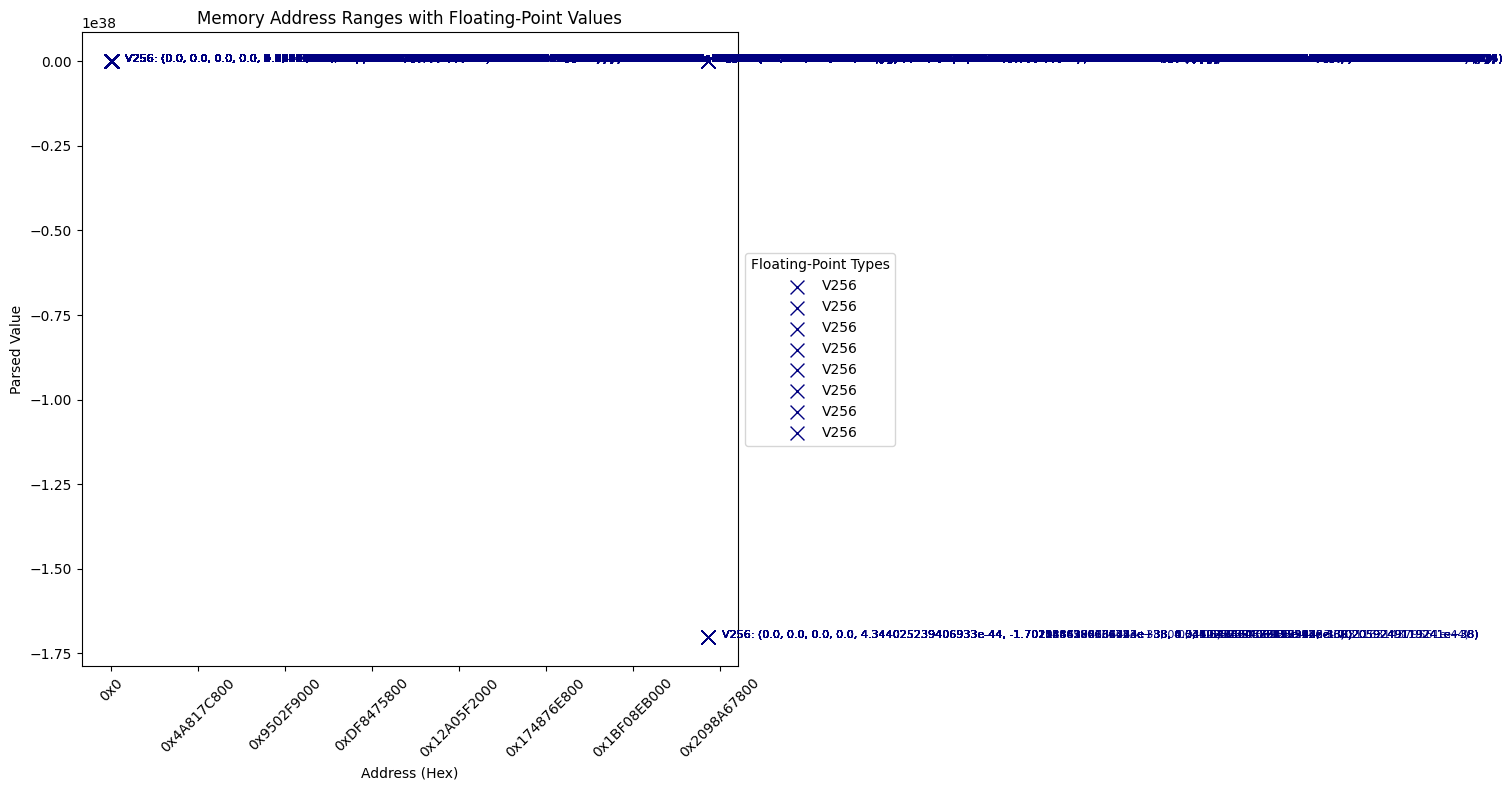

In [4]:
visualize_addresses_with_points(malloc_addresses, heap_writes)

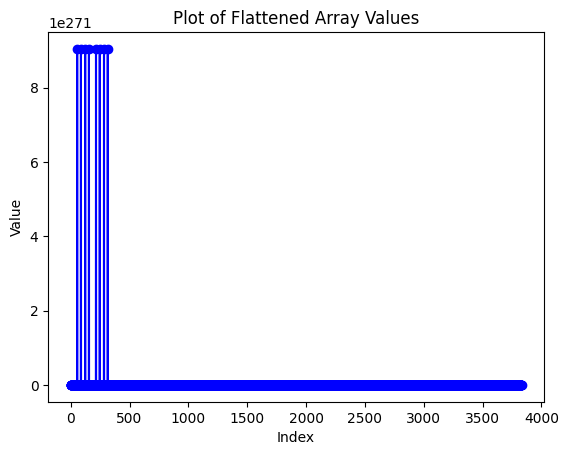

In [5]:
# Extract the third component from each tuple
third_components = [t[2] for t in heap_writes]
flattened_array = [item for sublist in third_components for item in sublist]

# Plot the flattened array
plt.plot(flattened_array, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of Flattened Array Values')

# Show the plot
plt.show()



In [6]:
import math

# Initialize counters
nan_count = 0
positive_count = 0
negative_count = 0
zero_count = 0
other_count = 0

# Iterate through the array and classify each number
for x in flattened_array:
    if math.isnan(x):
        nan_count += 1
    elif math.isinf(x):
        other_count += 1
    elif x > 0:
        positive_count += 1
    elif x < 0:
        negative_count += 1
    else:  # Handles zero, including -0.0
        zero_count += 1

# Print the results
print(f"Number of positive values: {positive_count}")
print(f"Number of negative values: {negative_count}")
print(f"Number of zeros: {zero_count}")
print(f"Number of NaN values: {nan_count}")
print(f"Number of other values (e.g., infinities): {other_count}")

Number of positive values: 603
Number of negative values: 0
Number of zeros: 3107
Number of NaN values: 122
Number of other values (e.g., infinities): 0


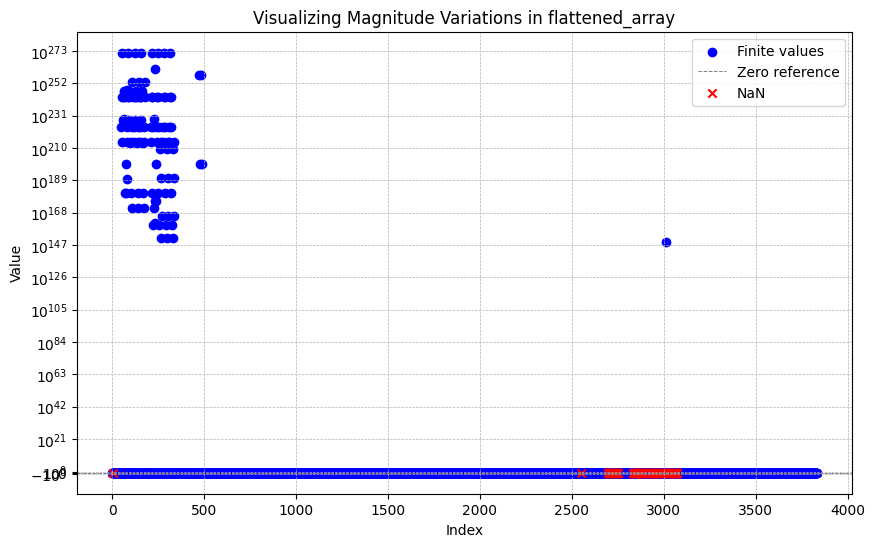

In [7]:
# Filter valid (finite) values for plotting
finite_values = [x for x in flattened_array if np.isfinite(x)]
finite_indices = [i for i, x in enumerate(flattened_array) if np.isfinite(x)]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(finite_indices, finite_values, color='blue', label='Finite values')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7, label='Zero reference')

# Add markers for special categories
for i, x in enumerate(flattened_array):
    if np.isnan(x):
        plt.scatter(i, 0, color='red', marker='x', label='NaN' if 'NaN' not in plt.gca().get_legend_handles_labels()[1] else None)
    elif np.isposinf(x):
        plt.scatter(i, 1, color='orange', marker='^', label='+Infinity' if '+Infinity' not in plt.gca().get_legend_handles_labels()[1] else None)
    elif np.isneginf(x):
        plt.scatter(i, -1, color='purple', marker='v', label='-Infinity' if '-Infinity' not in plt.gca().get_legend_handles_labels()[1] else None)

# Labels and legend
plt.title('Visualizing Magnitude Variations in flattened_array')
plt.xlabel('Index')
plt.ylabel('Value')
plt.yscale('symlog')  # Symmetric log scale to handle large magnitude variations
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [21]:
heap_writes

[(67301224,
  4366,
  (0.0, 0.0, 3.3158382e-316, 3.3158374e-316),
  'V256: (0.0, 0.0, 3.3158382e-316, 3.3158374e-316)'),
 (67302624, 4366, (0.0, 0.0, 0.0, nan), 'V256: (0.0, 0.0, 0.0, nan)'),
 (67302904,
  4366,
  (0.0, 0.0, 2.1265e-320, 6.26317e-319),
  'V256: (0.0, 0.0, 2.1265e-320, 6.26317e-319)'),
 (67303496, 4366, (0.0, 0.0, 0.0, 0.0), 'V256: (0.0, 0.0, 0.0, 0.0)'),
 (67303480, 4366, (0.0, 0.0, 0.0, 0.0), 'V256: (0.0, 0.0, 0.0, 0.0)'),
 (67303576, 4366, (0.0, 0.0, 0.0, 0.0), 'V256: (0.0, 0.0, 0.0, 0.0)'),
 (67303560, 4366, (0.0, 0.0, 0.0, 0.0), 'V256: (0.0, 0.0, 0.0, 0.0)'),
 (67303656, 4366, (0.0, 0.0, 0.0, 0.0), 'V256: (0.0, 0.0, 0.0, 0.0)'),
 (67303640, 4366, (0.0, 0.0, 0.0, 0.0), 'V256: (0.0, 0.0, 0.0, 0.0)'),
 (67303736, 4366, (0.0, 0.0, 0.0, 0.0), 'V256: (0.0, 0.0, 0.0, 0.0)'),
 (67303720, 4366, (0.0, 0.0, 0.0, 0.0), 'V256: (0.0, 0.0, 0.0, 0.0)'),
 (67300944,
  4366,
  (0.0, 0.0, 1.3755e-320, 9.17144e-319),
  'V256: (0.0, 0.0, 1.3755e-320, 9.17144e-319)'),
 (137422174336,
  